# RESULTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

%config IPCompleter.greedy=True

pd.options.display.max_columns = None

con = sa.create_engine('sqlite:///../Datos/airbnb.db')

df = pd.read_sql('df_preparado', con = con)

#Minicube:

metricas = ['precio_total','precio_compra']
dimensiones = ['bedrooms_disc','accommodates_disc','beds_disc','number_of_reviews_disc']

minicubo_precio = df[dimensiones + metricas]

minicubo_precio = minicubo_precio.melt(id_vars=['precio_total','precio_compra'])

minicubo_precio = minicubo_precio.groupby(['variable','value'])[['precio_total','precio_compra']].agg('median')

In [2]:
con = sa.create_engine('sqlite:///../Datos/airbnb.db')

df = pd.read_sql('df_preparado', con = con)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17710 entries, 0 to 17709
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   level_0                         17710 non-null  int64  
 1   index                           17710 non-null  int64  
 2   id                              17710 non-null  int64  
 3   name                            17707 non-null  object 
 4   host_id                         17710 non-null  int64  
 5   neighbourhood_group             17710 non-null  object 
 6   neighbourhood                   17710 non-null  object 
 7   latitude                        17710 non-null  float64
 8   longitude                       17710 non-null  float64
 9   room_type                       17710 non-null  object 
 10  price                           17710 non-null  int64  
 11  minimum_nights                  17710 non-null  int64  
 12  calculated_host_listings_count  

## CONTEXT OF THE ANALYSIS


The company has selected the city of Madrid as a candidate to search for properties in which to invest with the aim of obtaining profitability through tourist rentals.

To do this, before putting the valuation team to look for opportunities, management has commissioned the Data Science team to carry out a Discovery analysis to identify strategies or lines of work that help direct the actions of the valuation team.

## GOALS


* Analyze available public data sources
* To find insights that help understand the characteristics of the market in this city
* And guide the research work of the valuation team
* Especially regarding the main axes: rental price, occupancy levels and purchase price

## EXECUTIVE CONCLUSIONS


* 10 neighborhoods have been identified in which to focus the search
* It is recommended to look for properties with one room that can accommodate 3 guests
* It is recommended to look for properties that, while in one of the identified neighborhoods, are not necessarily close to points of interest
* It is recommended to evaluate the development of a new product based on rent for specific moments of high sporting interest, especially in the San Blas neighborhood

## DETAILS OF THE MAIN RESULTS


### There are 10 neighborhoods with high investment potential


* 10 neighborhoods have been located that can maximize the cost-income ratio
* In addition, we can segment them by the type and quality of the property in which we are interested in investing in 4 large groups
* These are the 10 neighborhoods where to start looking for specific opportunities:
* Low investment: Simancas, Ambroz, Marroquina, San Juan Bautista
* Medium investment: El Plantio, Valdemarín, Valdefuentes
* Medium-high investment: Jerónimos, Fuentela Reina
* High investment: Recoletos

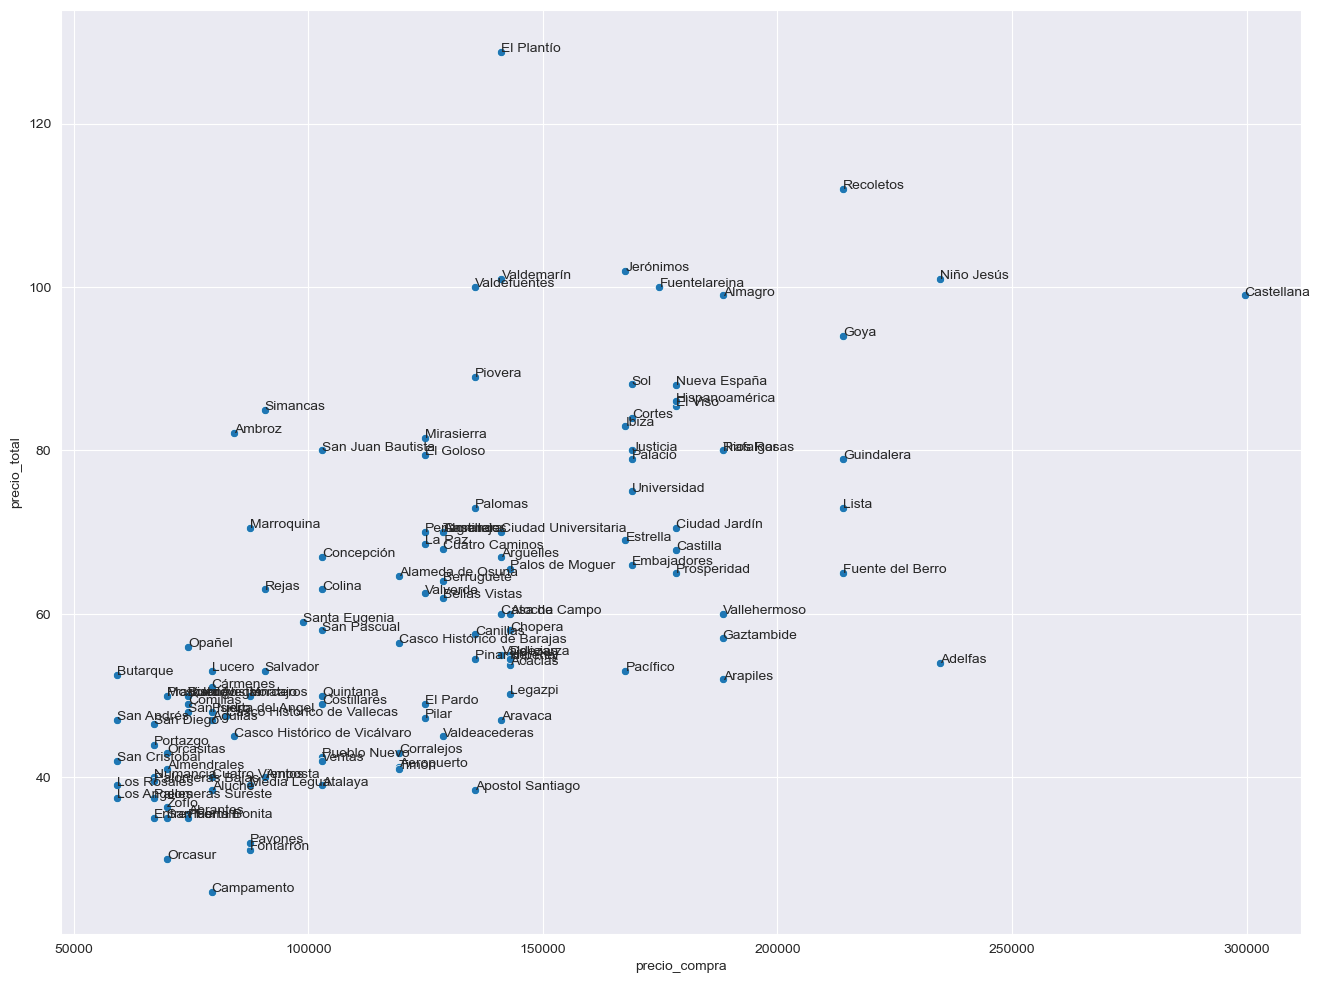

In [5]:
no_incluir = ['Rosas','Arcos','Canillejas','Hellín']

temp = df.groupby('neighbourhood')[['precio_total','precio_compra']].median()

temp = temp[~temp.index.isin(no_incluir)]

plt.figure(figsize = (16,12))
sns.set_style('darkgrid')
sns.scatterplot(data = temp, x = 'precio_compra', y = 'precio_total')
#Ponemos las etiquetas
for cada in range(0,temp.shape[0]):
    plt.text(temp.precio_compra.iloc[cada], temp.precio_total.iloc[cada], temp.index[cada])

### Find one-bedroom properties that allow 3 guests


* The number of guests that maximizes the purchase price paid is 3


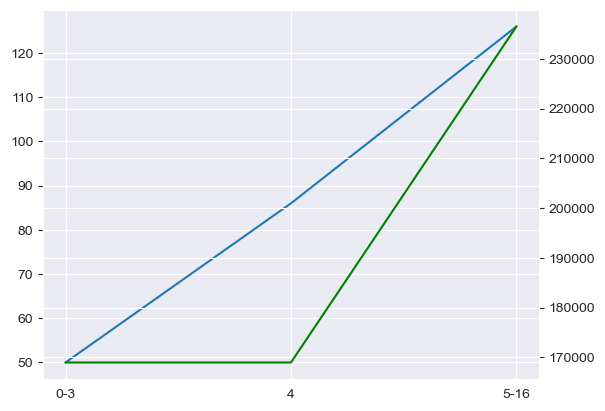

In [6]:
f, ax = plt.subplots()
ax.plot(minicubo_precio.loc['accommodates_disc'].precio_total)
ax2 = ax.twinx()
ax2.plot(minicubo_precio.loc['accommodates_disc'].precio_compra,color = 'green');

### Search for properties that, while in one of the identified neighborhoods, are not necessarily close to points of interest

* They will likely have a lower purchase price
* It seems that proximity to points of interest does not have a special impact on the rental price

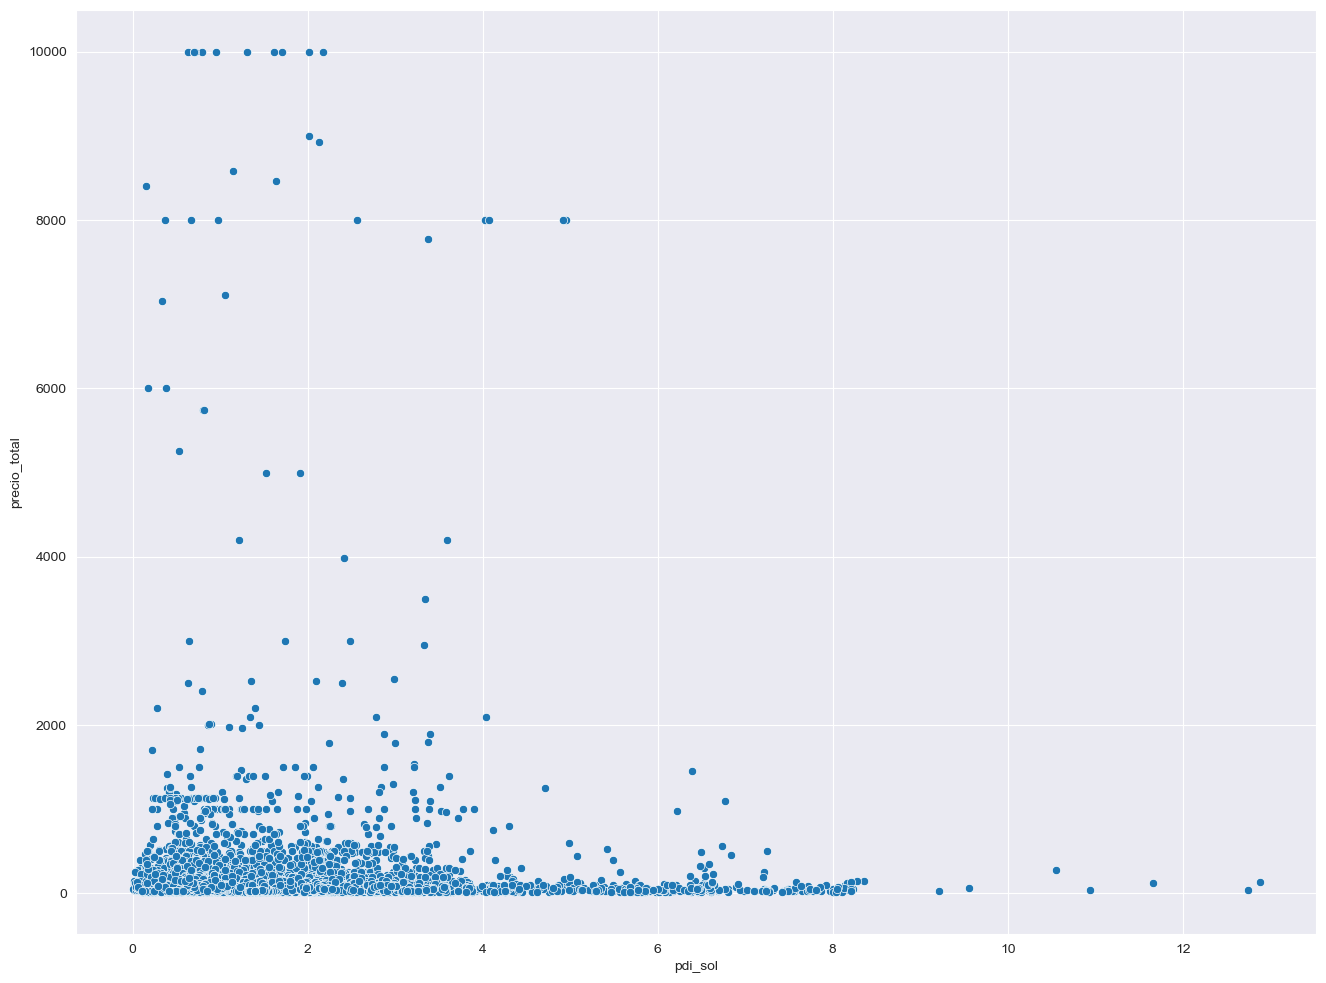

In [7]:
seleccion = df.groupby('distrito').pdi_sol.median().sort_values()[0:7].index.to_list()

plt.figure(figsize = (16,12))
sns.scatterplot(data = df.loc[df.distrito.isin(seleccion)], x = 'pdi_sol', y = 'precio_total');

### Evaluate the development of a new product based on rental for specific moments of high sporting interest

* Look for opportunities in the San Blas neighborhood
* There are still many rentals that are not exploiting this potential

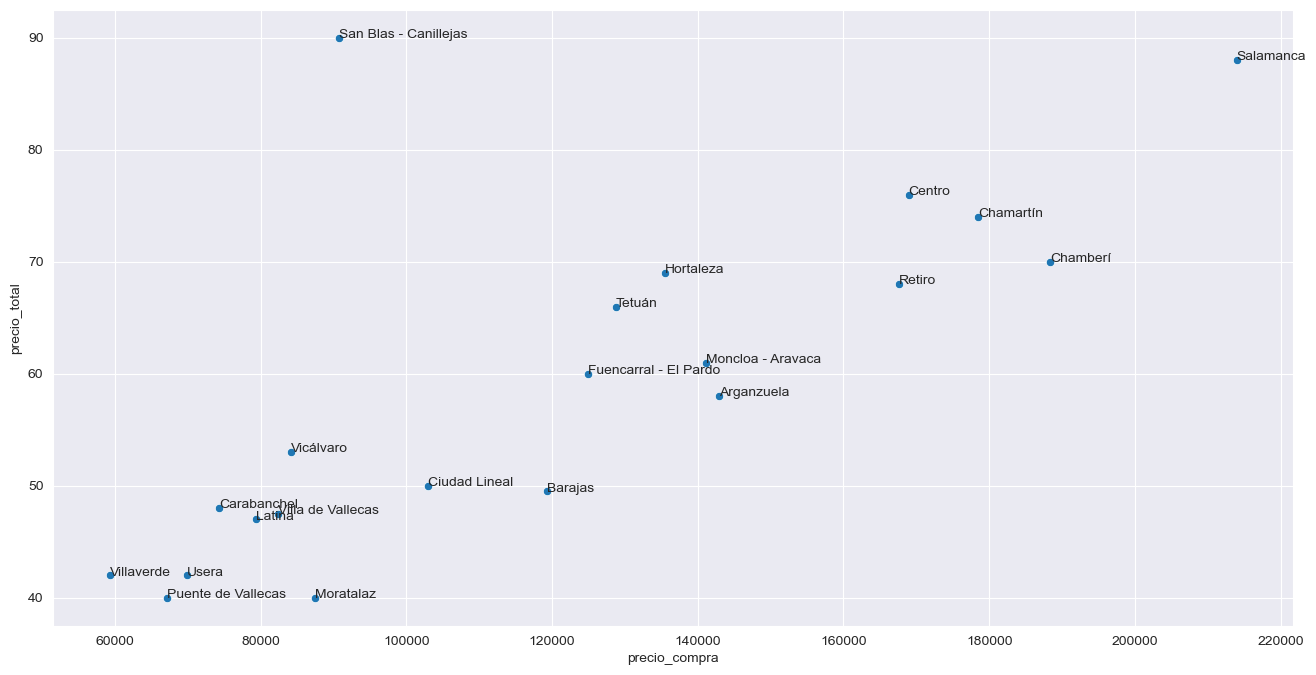

In [9]:
temp = df.groupby('distrito')[['precio_total','precio_compra']].median()

plt.figure(figsize = (16,8))
sns.scatterplot(data = temp, x = 'precio_compra', y = 'precio_total')
#Ponemos las etiquetas
for cada in range(0,temp.shape[0]):
    plt.text(temp.precio_compra.iloc[cada], temp.precio_total.iloc[cada], temp.index[cada])

In [10]:
import folium

datos = df[df.distrito == 'San Blas - Canillejas'].copy()

datos['precio_total_disc'] = pd.qcut(datos['precio_total'], q = [0, .25, .5, .75, 1.], 
                              labels=['yellow', 'orange', 'blue', 'red'])

mapa = folium.Map(location=[datos.iloc[0,7], datos.iloc[0,8]],zoom_start=14)

for piso in range(0,len(datos)):
   folium.CircleMarker(
      location = [datos.iloc[piso]['latitude'], datos.iloc[piso]['longitude']],
      popup = datos.iloc[piso]['precio_total'],
      fill=True,
      color = datos.iloc[piso]['precio_total_disc'],
      fill_opacity=1,
      radius = 5
   ).add_to(mapa)

mapa